In [10]:
import os
import numpy as np
from skimage import io, color, feature, exposure

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, log_loss
from sklearn.preprocessing import label_binarize

In [11]:

def extract_hog_features(image):
    gray_image = color.rgb2gray(image)
    hog_features, _ = feature.hog(gray_image, visualize=True)
    return hog_features

train_images_path = 'C:/Users/Ahmed/Desktop/archive/few_train/images'
train_labels_path = 'C:/Users/Ahmed/Desktop/archive/few_train/labels'

test_images_path = 'C:/Users/Ahmed/Desktop/archive/few_test/images'
test_labels_path = 'C:/Users/Ahmed/Desktop/archive/few_test/labels'

In [ ]:

train_features_list = []
train_labels_list = []

for image_filename in os.listdir(train_images_path):
    image_path = os.path.join(train_images_path, image_filename)
    image = io.imread(image_path)
    hog_features = extract_hog_features(image)
    label_filename = os.path.splitext(image_filename)[0] + '.txt'
    label_path = os.path.join(train_labels_path, label_filename)

    try:
        with open(label_path, 'r') as label_file:
            class_label = int(label_file.readline().split()[0])
        train_features_list.append(hog_features)
        train_labels_list.append(class_label)
    except Exception as e:
        print(f"Error processing {label_path}: {e}")

In [ ]:
test_features_list = []
test_labels_list = []
for image_filename in os.listdir(test_images_path):
    image_path = os.path.join(test_images_path, image_filename)
    image = io.imread(image_path)
    hog_features = extract_hog_features(image)
    label_filename = os.path.splitext(image_filename)[0] + '.txt'
    label_path = os.path.join(test_labels_path, label_filename)
    try:
        with open(label_path, 'r') as label_file:
            class_label = int(label_file.readline().split()[0])
        test_features_list.append(hog_features)
        test_labels_list.append(class_label)
    except Exception as e:
        print(f"Error processing {label_path}: {e}")

In [ ]:
X_train = np.array(train_features_list)
y_train = np.array(train_labels_list)

X_test = np.array(test_features_list)
y_test = np.array(test_labels_list)

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_normalized, y_train)
y_test_pred = model.predict(X_test_normalized)

accuracy_test = accuracy_score(y_test, y_test_pred)
classification_rep_test = classification_report(y_test, y_test_pred)

In [15]:
print(f"Accuracy on Test Set: {accuracy_test}")

print("Classification Report for Test Set:")
print(classification_rep_test)

Accuracy on Test Set: 0.7428571428571429
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.81      0.57      0.67        46
           1       0.60      0.55      0.57        33
           2       0.85      0.80      0.82       188
           3       0.59      0.80      0.68        82
           4       0.00      0.00      0.00         1

    accuracy                           0.74       350
   macro avg       0.57      0.54      0.55       350
weighted avg       0.76      0.74      0.74       350



C:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

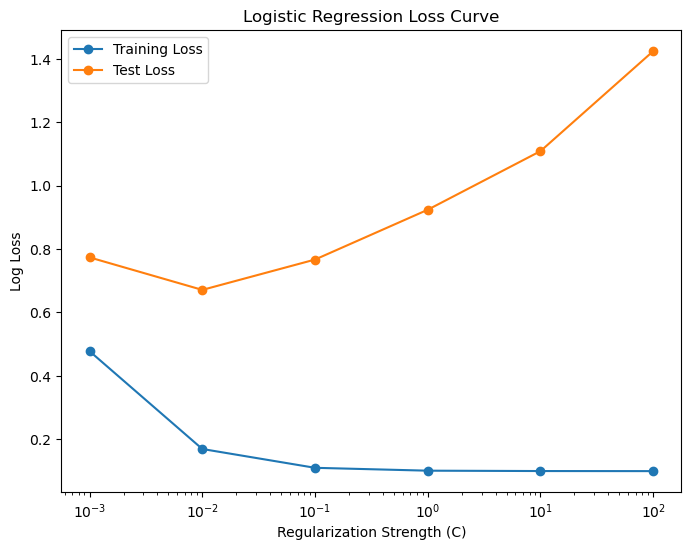

In [16]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
train_losses = []
test_losses = []

for C in C_values:
    model = LogisticRegression(C=C, multi_class='multinomial', solver='lbfgs')
    model.fit(X_train, y_train)
    y_train_proba = model.predict_proba(X_train)
    train_loss = log_loss(y_train, y_train_proba)
    train_losses.append(train_loss)
    y_test_proba = model.predict_proba(X_test)
    test_loss = log_loss(y_test, y_test_proba)
    test_losses.append(test_loss)
plt.figure(figsize=(8, 6))
plt.plot(C_values, train_losses, marker='o', label='Training Loss')
plt.plot(C_values, test_losses, marker='o', label='Test Loss')
plt.xscale('log')
plt.title('Logistic Regression Loss Curve')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

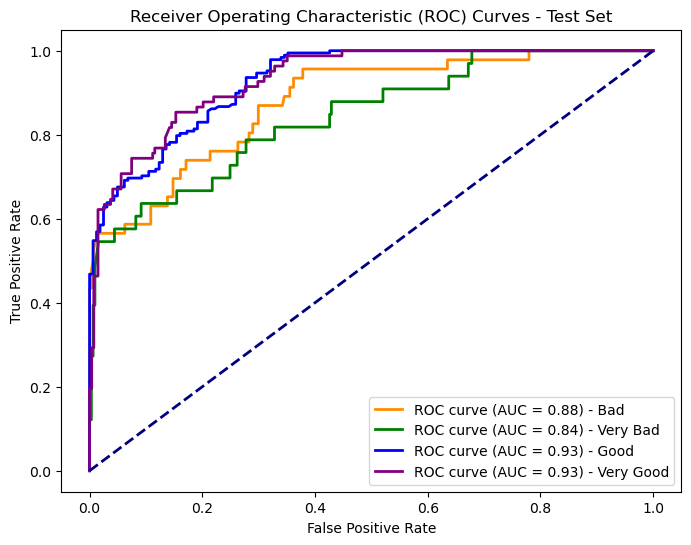

In [17]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()
class_names = ["Bad", "Very Bad", "Good", "Very Good","Unknown"]

for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue', 'purple'] 
for i, color in zip(range(len(np.unique(y_test))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) - {class_names[i]}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curves - Test Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

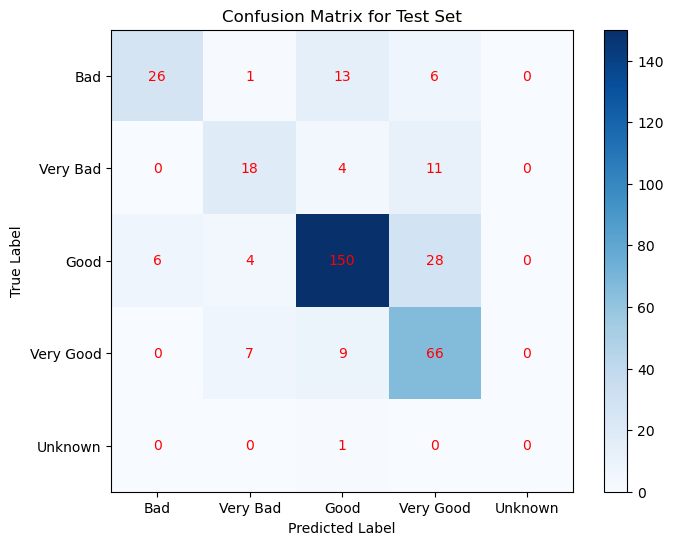

In [18]:
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

class_names = ["Bad", "Very Bad", "Good", "Very Good", "Unknown"]

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_test, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Set')
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix_test[i, j]), ha='center', va='center', color='red')
plt.show()